# 9.10 全卷积网络（FCN）

上一节介绍了，我们可以基于语义分割对图像中的每个像素进行类别预测。全卷积网络（fully convolutional network，FCN）采用卷积神经网络实现了从图像像素到像素类别的变换 [1]。与之前介绍的卷积神经网络有所不同，全卷积网络通过转置卷积（transposed convolution）层将中间层特征图的高和宽变换回输入图像的尺寸，从而令预测结果与输入图像在空间维（高和宽）上一一对应：给定空间维上的位置，通道维的输出即该位置对应像素的类别预测。

我们先导入实验所需的包或模块，然后解释什么是转置卷积层。

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,initializers,applications
import numpy as np
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_tensorflow
import matplotlib.pyplot as plt
import d2lzh_tensorflow2 as d2lzh

## 9.10.1 转置卷积层

顾名思义，转置卷积层得名于矩阵的转置操作。事实上，卷积运算还可以通过矩阵乘法来实现。在下面的例子中，我们定义高和宽分别为4的输入`X`，以及高和宽分别为3的卷积核`K`。打印二维卷积运算的输出以及卷积核。可以看到，输出的高和宽分别为2。

In [26]:
X = np.arange(1, 17).reshape((1, 4, 4, 1))
X=tf.convert_to_tensor(X, dtype=tf.float32)
K = np.arange(1, 10).reshape((1, 1, 3, 3))
K = initializers.Constant(K)
conv = layers.Conv2D(filters=1, kernel_size=3, kernel_initializer=K)
conv(X),np.shape(K.value)

(<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
 array([[[[348.],
          [393.]],
 
         [[528.],
          [573.]]]], dtype=float32)>, (1, 1, 3, 3))

下面我们将卷积核`K`改写成含有大量零元素的稀疏矩阵`W`，即权重矩阵。权重矩阵的形状为(4, 16)，其中的非零元素来自卷积核`K`中的元素。将输入`X`逐行连结，得到长度为16的向量。然后将`W`与向量化的`X`做矩阵乘法，得到长度为4的向量。对其变形后，我们可以得到和上面卷积运算相同的结果。可见，我们在这个例子中使用矩阵乘法实现了卷积运算。

In [27]:
W, k = np.zeros((4, 16)), np.zeros(11)
k[:3], k[4:7], k[8:] = K.value[0, 0, 0, :], K.value[0, 0, 1, :], K.value[0, 0, 2, :]
W[0, 0:11], W[1, 1:12], W[2, 4:15], W[3, 5:16] = k, k, k, k
tf.matmul(tf.convert_to_tensor(W, dtype=tf.float32), tf.reshape(X, (-1, 1))), W

(<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[348.],
        [393.],
        [528.],
        [573.]], dtype=float32)>,
 array([[1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0.],
        [0., 0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9.]]))

现在我们从矩阵乘法的角度来描述卷积运算。设输入向量为$\boldsymbol{x}$，权重矩阵为$\boldsymbol{W}$，卷积的前向计算函数的实现可以看作将函数输入乘以权重矩阵，并输出向量$\boldsymbol{y} = \boldsymbol{W}\boldsymbol{x}$。我们知道，反向传播需要依据链式法则。由于$\nabla_{\boldsymbol{x}} \boldsymbol{y} = \boldsymbol{W}^\top$，卷积的反向传播函数的实现可以看作将函数输入乘以转置后的权重矩阵$\boldsymbol{W}^\top$。而转置卷积层正好交换了卷积层的前向计算函数与反向传播函数：转置卷积层的这两个函数可以看作将函数输入向量分别乘以$\boldsymbol{W}^\top$和$\boldsymbol{W}$。

不难想象，转置卷积层可以用来交换卷积层输入和输出的形状。让我们继续用矩阵乘法描述卷积。设权重矩阵是形状为$4\times16$的矩阵，对于长度为16的输入向量，卷积前向计算输出长度为4的向量。假如输入向量的长度为4，转置权重矩阵的形状为$16\times4$，那么转置卷积层将输出长度为16的向量。在模型设计中，转置卷积层常用于将较小的特征图变换为更大的特征图。在全卷积网络中，当输入是高和宽较小的特征图时，转置卷积层可以用来将高和宽放大到输入图像的尺寸。

我们来看一个例子。构造一个卷积层`conv`，并设输入`X`的形状为(1, 64, 64, 3)。卷积输出`Y`的通道数增加到10，但高和宽分别缩小了一半。

In [28]:
conv = layers.Conv2D(10, 4, padding='same', strides=2)

x = np.random.uniform(size=(1, 64, 64, 3))
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = conv(x)
y.shape

TensorShape([1, 32, 32, 10])

下面我们通过创建`Conv2DTranspose`实例来构造转置卷积层`conv_trans`。这里我们设`conv_trans`的卷积核形状、填充以及步幅与`conv`中的相同，并设输出通道数为3。当输入为卷积层`conv`的输出`Y`时，转置卷积层输出与卷积层输入的高和宽相同：转置卷积层将特征图的高和宽分别放大了2倍。

In [29]:
conv_trans = layers.Convolution2DTranspose(filters=3,
                          kernel_size=4,
                          padding='same',
                          strides=2)
conv_trans(y).shape

TensorShape([1, 64, 64, 3])

在有些文献中，转置卷积也被称为分数步长卷积（fractionally-strided convolution）[2]。


## 9.10.2 构造模型

我们在这里给出全卷积网络模型最基本的设计。如图9.11所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。模型输出与输入图像的高和宽相同，并在空间位置上一一对应：最终输出的通道包含了该空间位置像素的类别预测。

![全卷积网络](http://zh.d2l.ai/_images/fcn.svg)

下面我们使用一个基于ImageNet数据集预训练的ResNet-101模型来抽取图像特征，并将该网络实例记为`pretrained_net`。

In [30]:
pretrained_net = applications.ResNet101V2(include_top=False, weights='imagenet', input_shape=(320, 480, 3))
pretrained_net.layers[-4:], pretrained_net.output

([<tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fee08bc7908>,
 <tf.Tensor 'post_relu_1/Identity:0' shape=(None, 10, 15, 2048) dtype=float32>)

下面我们创建全卷积网络实例`net`。它复制了`pretrained_net`实例成员变量`features`里除去最后两层的所有层以及预训练得到的模型参数。

In [0]:
net = keras.Sequential()
net.add(pretrained_net)

给定高和宽分别为320和480的输入，net的前向计算将输入的高和宽减小至原来的 1/32 ，即10和15。

In [32]:
x = np.random.uniform(size=(1, 320, 480, 3))
x = tf.convert_to_tensor(x, dtype=tf.float32)
net(x).shape

TensorShape([1, 10, 15, 2048])

接下来，我们通过$1\times 1$卷积层将输出通道数变换为Pascal VOC2012数据集的类别个数21。最后，我们需要将特征图的高和宽放大32倍，从而变回输入图像的高和宽。回忆一下[“填充和步幅”](../chapter_convolutional-neural-networks/padding-and-strides.ipynb)一节中描述的卷积层输出形状的计算方法。由于$(320-64+16\times2+32)/32=10$且$(480-64+16\times2+32)/32=15$，我们构造一个步幅为32的转置卷积层，并将卷积核的高和宽设为64、填充设为16。不难发现，如果步幅为$s$、填充为$s/2$（假设$s/2$为整数）、卷积核的高和宽为$2s$，转置卷积核将输入的高和宽分别放大$s$倍。

In [33]:
num_classes = 21
net.add(keras.layers.Conv2D(num_classes, kernel_size=1, activation='relu'))
print(net(x).shape)
net.add(keras.layers.Conv2DTranspose(num_classes,
                kernel_size=64,
                padding='same',
                strides=32))
print(net(x).shape)
net.add(keras.layers.Softmax(axis=-1))

(1, 10, 15, 21)
(1, 320, 480, 21)


## 9.10.3 初始化转置卷积层

我们已经知道，转置卷积层可以放大特征图。在图像处理中，我们有时需要将图像放大，即上采样（upsample）。上采样的方法有很多，常用的有双线性插值。简单来说，为了得到输出图像在坐标$(x,y)$上的像素，先将该坐标映射到输入图像的坐标$(x',y')$，例如，根据输入与输出的尺寸之比来映射。映射后的$x'$和$y'$通常是实数。然后，在输入图像上找到与坐标$(x',y')$最近的4个像素。最后，输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算。双线性插值的上采样可以通过由以下`bilinear_kernel`函数构造的卷积核的转置卷积层来实现。限于篇幅，我们只给出`bilinear_kernel`函数的实现，不再讨论算法的原理。

In [0]:
# 目的就是找出 kernel_size*kernel_size 的框，框内的权值中间大外面小
# 然后每个通道只乘以自己的权值 就像上面图一样（kernel_size=2）
# 每个channel乘以对应的权值
# in_channels, out_channels 应该相同

def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1-abs(og[0]-center)/factor) * (1-abs(og[1]-center)/factor)

    # kernel_size = (kernel_size, kernel_size, in_channels, out_channels)
    weight = np.zeros((kernel_size, kernel_size, in_channels, out_channels), dtype='float32')
    weight[:, :, range(in_channels), range(out_channels)] = filt.reshape((kernel_size,kernel_size,1))
    return weight

我们来实验一下用转置卷积层实现的双线性插值的上采样。构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用`bilinear_kernel`函数初始化。

In [0]:
init_param = initializers.Constant(bilinear_kernel(3,3,4))
conv_trans = layers.Conv2DTranspose(3,
                kernel_size=4,
                padding='same',
                strides=2,
                kernel_initializer=init_param,)

读取图像`X`，将上采样的结果记作`Y`。为了打印图像，我们需要调整通道维的位置。

(561, 728, 3)


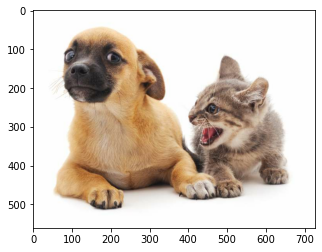

In [36]:
img = tf.io.read_file('../../docs/img/chapter09/9.10/catdog.jpg')
img_org = tf.image.decode_jpeg(img, channels=3)

img = tf.cast(img_org, tf.float32)/255.
print(img.shape)
plt.imshow(img.numpy())

(1, 1122, 1456, 3)


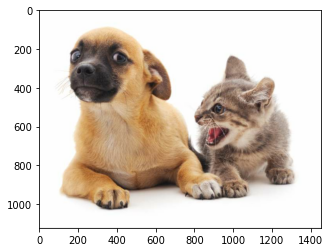

In [37]:
# 增加维度
y = conv_trans(tf.expand_dims(img, axis=0))
print(y.shape)
# 颜色会变浅
plt.imshow(y[0])

在全卷积网络中，我们将转置卷积层初始化为双线性插值的上采样。对于 1×1 卷积层，我们采用Xavier随机初始化。

In [38]:
net.layers

In [39]:
for i in range(-2, -1):
    bias_weight = net.layers[i].get_weights()[1]
    kernel_size = net.layers[i].get_config()['kernel_size'][0]
    net.layers[i].set_weights([bilinear_kernel(num_classes, num_classes, kernel_size), 
                bias_weight])

for i in range(4):
    print(net.layers[i].trainable)
# net[-3] 不需要动了，tf默认Xavier初始化

True
True
True
True


## 9.10.4 读取数据集

我们用上一节介绍的方法读取数据集。这里指定随机裁剪的输出图像的形状为$320\times 480$：高和宽都可以被32整除。

In [40]:
crop_size = (320, 480)
batch_size = 32
colormap2label = np.zeros(256 ** 3, dtype=np.uint8)

for i, colormap in enumerate(d2lzh.VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

colormap2label = tf.convert_to_tensor(colormap2label)
voc_dir = "../../data/VOCdevkit/VOC2012"

voc_train = d2lzh.getVOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = d2lzh.getVOCSegDataset(False, crop_size, voc_dir, colormap2label)

batch_size = 16
voc_train = voc_train.shuffle(buffer_size=1024).batch(batch_size)
voc_test = voc_test.shuffle(buffer_size=1024).batch(batch_size)

1464it [00:13, 104.81it/s]


read 1114 valid examples


1449it [00:14, 100.83it/s]


read 1078 valid examples


## 9.10.5 训练模型

现在可以开始训练模型了。这里的损失函数和准确率计算与图像分类中的并没有本质上的不同。因为我们使用转置卷积层的通道来预测像素的类别，所以在`SoftmaxCrossEntropyLoss`里指定了`axis=1`（通道维）选项。此外，模型基于每个像素的预测类别是否正确来计算准确率。

In [41]:
# 检查输入输出是否正确
for x, y in iter(voc_test):
    pred = net.predict(x)
    pred = tf.convert_to_tensor(pred)
    print(x.shape, y.shape, y[0, 170, 240])
    print(net(x).shape)
    break

(16, 320, 480, 3) (16, 320, 480) tf.Tensor(17, shape=(), dtype=uint8)
(16, 320, 480, 21)


In [42]:
net.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=['accuracy'])
net.output

<tf.Tensor 'softmax_1/Identity:0' shape=(None, 320, 480, 21) dtype=float32>

In [43]:
net.fit(voc_train, epochs=5, validation_data=voc_test)

Epoch 1/5
70/70 [==============================] - 150s 2s/step - loss: 1.3498 - accuracy: 0.7080 - val_loss: 30.3679 - val_accuracy: 0.7275
Epoch 2/5
70/70 [==============================] - 149s 2s/step - loss: 1.0815 - accuracy: 0.7402 - val_loss: 1.9898 - val_accuracy: 0.5296
Epoch 3/5
70/70 [==============================] - 149s 2s/step - loss: 0.9551 - accuracy: 0.7548 - val_loss: 1.5803 - val_accuracy: 0.5949
Epoch 4/5
70/70 [==============================] - 149s 2s/step - loss: 0.8371 - accuracy: 0.7728 - val_loss: 1.4259 - val_accuracy: 0.6343
Epoch 5/5
70/70 [==============================] - 149s 2s/step - loss: 0.7473 - accuracy: 0.7886 - val_loss: 0.9906 - val_accuracy: 0.7278


## 9.10.6 预测像素类别

在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。

In [0]:
def predict(img):
    rgb_mean = np.array([0.485, 0.456, 0.406])
    rgb_std = np.array([0.229, 0.224, 0.225])
    feature = tf.cast(img, tf.float32)
    feature = tf.divide(feature, 255.)
    # feature = tf.divide(tf.subtract(feature, rgb_mean), rgb_std)
    x = tf.expand_dims(feature, axis=0)
    return net.predict(x)

为了可视化每个像素的预测类别，我们将预测类别映射回它们在数据集中的标注颜色。

In [0]:
def label2image(pred):
    colormap = np.array(d2lzh.VOC_COLORMAP, dtype='float32')
    x = colormap[tf.argmax(pred, axis=-1)]
    # print(pred[0, 160, 200])
    return x

测试数据集中的图像大小和形状各异。由于模型使用了步幅为32的转置卷积层，当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向计算。这些区域的并集需要完整覆盖输入图像。当一个像素被多个区域所覆盖时，它在不同区域前向计算中转置卷积层输出的平均值可以作为softmax运算的输入，从而预测类别。

简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为 320×480 的区域：只有该区域用于预测。对于输入图像，我们先打印截取的区域，再打印预测结果，最后打印标注的类别。



10it [00:00, 115.97it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee02f5a0f0>,
      dtype=object)

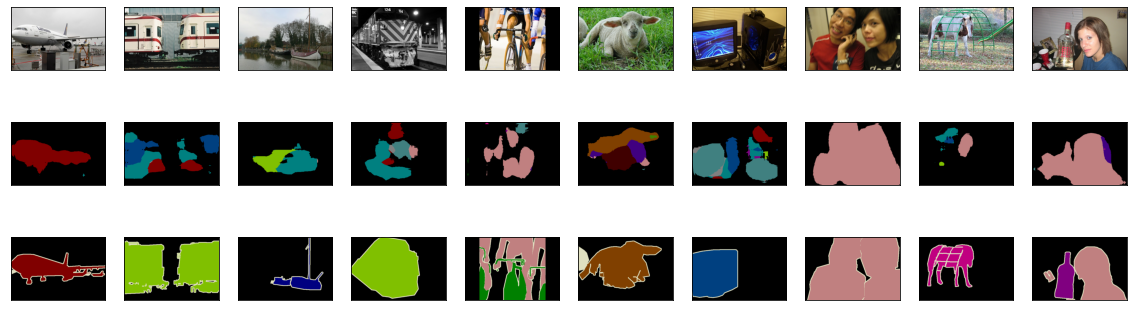

In [50]:
n = 10
imgs = []
test_images, test_labels = d2lzh.read_voc_images(is_train=False, max_num=n)
for i in range(n):
    x = tf.image.resize_with_crop_or_pad(test_images[i], 320, 480)
    pred = predict(x)
    pred = label2image(pred)
    pred = tf.cast(pred, tf.uint8)
    imgs += [x, pred, tf.image.resize_with_crop_or_pad(test_labels[i], 320, 480)]

d2lzh.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n)

## 9.10.7 小结

* 可以通过矩阵乘法来实现卷积运算。
* 全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸，从而输出每个像素的类别。
* 在全卷积网络中，可以将转置卷积层初始化为双线性插值的上采样。


## 9.10.8 练习

* 用矩阵乘法来实现卷积运算是否高效？为什么？
* 如果将转置卷积层改用Xavier随机初始化，结果有什么变化？
* 调节超参数，能进一步提升模型的精度吗？
* 预测测试图像中所有像素的类别。
* 全卷积网络的论文中还使用了卷积神经网络的某些中间层的输出 [1]。试着实现这个想法。




## 9.10.9 参考文献

[1] Long, J., Shelhamer, E., & Darrell, T. (2015). Fully convolutional networks for semantic segmentation. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 3431-3440).

[2] Dumoulin, V., & Visin, F. (2016). A guide to convolution arithmetic for deep learning. arXiv preprint arXiv:1603.07285.